# SMS Spam Classification

This notebook illustrates classification of SMS as SPAM or NOT SPAM. 

### Installing Dependicies

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
#from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
#from sklearn.learning_curve import learning_curve

## Preprocessing and Exploring the Dataset

Importing the Dataset spam.csv

In [4]:
data = pd.read_csv('data/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Removing unwanted columns

In [5]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})

In [6]:
data[1990:2000]

,label,text
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...
1991,ham,No other Valentines huh? The proof is on your ...
1992,spam,Free tones Hope you enjoyed your new content. ...
1993,ham,Eh den sat u book e kb liao huh...
1994,ham,Have you been practising your curtsey?
1995,ham,Shall i come to get pickle
1996,ham,Lol boo I was hoping for a laugh
1997,ham,\YEH I AM DEF UP4 SOMETHING SAT
1998,ham,"Well, I have to leave for my class babe ... Yo..."
1999,ham,LMAO where's your fish memory when I need it?


In [7]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### Some Visualisations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FDC28C3B00>]],
      dtype=object)

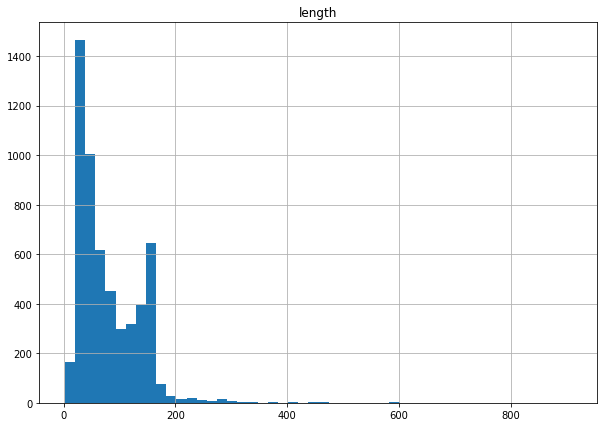

In [27]:
data['length'] = data['text'].map(lambda x: len(x))
data.hist(column='length',bins=50, figsize=(10,7))

In [28]:
data.describe()

,label,length
count,5572.000000,5572.000000
mean,0.134063,80.118808
std,0.340751,59.690841
min,0.000000,2.000000
25%,0.000000,36.000000
50%,0.000000,61.000000
75%,0.000000,121.000000
max,1.000000,910.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FDC2834EB8>,
      dtype=object)

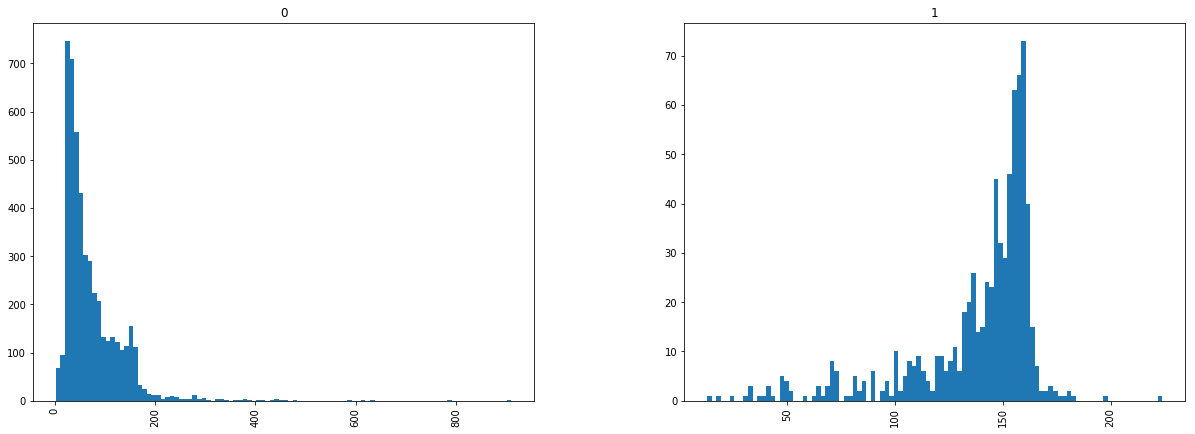

In [29]:
data.hist(column='length', by='label', bins=100, figsize=(20,7))

In [30]:
import nltk
#nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

### WordClouds- to see which words are common in SPAM and NOT SPAM mesaages

In [31]:
ham_words = ''
spam_words = ''

In [32]:
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [33]:
# spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
# ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

In [34]:
#Spam Word cloud
# plt.figure( figsize=(10,8), facecolor='w')
# plt.imshow(spam_wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

In [35]:
# plt.figure( figsize=(10,8), facecolor='g')
# plt.imshow(ham_wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

In [36]:
data = data.replace(['ham','spam'],[0, 1]) 

In [37]:
data.head(10)

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
5,1,FreeMsg Hey there darling it's been 3 week's n...,148
6,0,Even my brother is not like to speak with me. ...,77
7,0,As per your request 'Melle Melle (Oru Minnamin...,160
8,1,WINNER!! As a valued network customer you have...,158
9,1,Had your mobile 11 months or more? U R entitle...,154


In [43]:
# nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\108117035\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Removing Stopwords from the messages

In [47]:
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [48]:
data['text'] = data['text'].apply(text_process)

In [49]:
data.head()

,label,text,length
0,0,Go jurong point crazy Available bugis n great ...,111
1,0,Ok lar Joking wif u oni,29
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...,155
3,0,U dun say early hor U c already say,49
4,0,Nah dont think goes usf lives around though,61


In [51]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

# Converting words to vectors

- First create a vocabulary of all words in the dataset (text messages)

- #### Vector created as follows :
 - positions with respect to highest occuring word
 - Eg : 1 at first index means first word in vocab(most frequent occuring in vocab which is 'of') occurs twice in this sentence

In [52]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  11305


In [53]:
## Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'make', 'give', 'new']


In [54]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [55]:
### Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [56]:
## Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])

In [57]:
word_vectors.shape

(5572, 11305)

## Converting words to vectors using TFIDF Vectorizer

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 9376)

## Choosing which algorithm we want to use a features : TFIDF or using custom vocabulary ?

In [59]:
#features = word_vectors
features = vectors

### Splitting into training and test set

In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

NameError: name 'train_test_split' is not defined

In [61]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

NameError: name 'X_train' is not defined

## Classifying using sklearn pre built classifiers

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [63]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [64]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [65]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [66]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

NameError: name 'X_train' is not defined

## Predictions using TFIDF Vectorizer algorithm

In [67]:
predictions = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
predictions

NameError: name 'pred_scores' is not defined

## Predictions using custom vocabulary

In [68]:
predictions_word_vectors = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score_'])
predictions_word_vectors

ValueError: not enough values to unpack (expected 2, got 0)

## Plot of scores TFIDF Vectorizer algorithm

In [69]:
predictions.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

NameError: name 'predictions' is not defined

## Plot of scores custom vocabulary

In [70]:
predictions_word_vectors.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions_word_vectors.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier - Word Vectors')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

NameError: name 'predictions_word_vectors' is not defined

In [71]:
def find(p):
    if p == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [72]:
text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)

In [73]:
p = mnb.predict(integers)[0]
find(p)        

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Saving the Best Model

In [74]:
from sklearn.externals import joblib
joblib.dump(mnb, 'best.pkl')
print ("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [75]:
best = joblib.load('best.pkl')

In [76]:
best

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

## Testing our classifiers

In [77]:
text1 = ["Free tones Hope you enjoyed your new content"]
text2 = ["No. I meant the calculation is the same. That I'll call later"]
text3 = ["Had your contract mobile 11 Mnths? Latest Motorola Now"]
text4 = ["WINNER!! You just won a free ticket to Bahamas. Send your Details"]

integers1 = vectorizer.transform(text1)
integers2 = vectorizer.transform(text2)
integers3 = vectorizer.transform(text3)
integers4 = vectorizer.transform(text4)

In [78]:
p1 = best.predict(integers)[0]
p2 = best.predict(integers)[0]
p3 = best.predict(integers)[0]
p4 = best.predict(integers)[0]

find(p1)
find(p2)
find(p3)
find(p4)

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.